# Uber Supply-Demand Gap

In [2]:
#importing the libraries required during the analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#importing the Data into uber_df dataframe
uber_df = pd.read_csv("UberRequestData.csv")

uber_df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,11/7/2016 11:51,11/7/2016 13:00
1,867,Airport,1.0,Trip Completed,11/7/2016 17:57,11/7/2016 18:47
2,1807,City,1.0,Trip Completed,12/7/2016 9:17,12/7/2016 9:58
3,2532,Airport,1.0,Trip Completed,12/7/2016 21:08,12/7/2016 22:03
4,3112,City,1.0,Trip Completed,13-07-2016 08:33:16,13-07-2016 09:25:47


In [3]:
#converting the Request timestamp and Drop timestamp into common datetime format
uber_df['Request timestamp'] = pd.to_datetime(uber_df['Request timestamp'])
uber_df['Drop timestamp'] = pd.to_datetime(uber_df['Drop timestamp'])

uber_df

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47
...,...,...,...,...,...,...
6740,6745,City,NaN,No Cars Available,2016-07-15 23:49:03,NaT
6741,6752,Airport,NaN,No Cars Available,2016-07-15 23:50:05,NaT
6742,6751,City,NaN,No Cars Available,2016-07-15 23:52:06,NaT
6743,6754,City,NaN,No Cars Available,2016-07-15 23:54:39,NaT


In [4]:
#check the info on the dataframe
uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   int64         
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   float64       
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(2)
memory usage: 316.3+ KB


Here we can clearly see there are two columns with NaN and NaT values for the obvious reasons of `Driver id` being Null for the requests where Cars were not available and `Drop timestamp` missing for the request which were not served either due to Cancellation by Driver or Unavailability of Cars.

But before we move on let's validate our assumption first,

In [5]:
#check if there are any observations where Cars' availability was not an issue and the Driver id is still missing
uber_df[(uber_df['Status'] != 'No Cars Available') & uber_df['Driver id'].isnull()].count()

Request id           0
Pickup point         0
Driver id            0
Status               0
Request timestamp    0
Drop timestamp       0
dtype: int64

In [6]:
#check if there are any observations where Drop timestamp is missing for Completed trips
uber_df[(uber_df['Status'] == 'Trip Completed') & uber_df['Drop timestamp'].isnull()].count()

Request id           0
Pickup point         0
Driver id            0
Status               0
Request timestamp    0
Drop timestamp       0
dtype: int64

Therefore, the data is complete.

Now, let's add some *Derived metrics* to the dataframe

In [7]:
#adding two new columns Request Day and Request Hour to the dataframe
uber_df['Request Day'] = pd.DatetimeIndex(uber_df['Request timestamp']).day_name()
uber_df['Request Hour'] = pd.DatetimeIndex(uber_df['Request timestamp']).hour

uber_df.head()

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Day,Request Hour
0,619,Airport,1.0,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Monday,11
1,867,Airport,1.0,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Monday,17
2,1807,City,1.0,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Wednesday,9
3,2532,Airport,1.0,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Wednesday,21
4,3112,City,1.0,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Wednesday,8


Also, let's convert the dtype of both ID columns to be object type

In [8]:
#converting the dtype of ID columns 
uber_df['Request id'] = uber_df['Request id'].astype('object')
uber_df['Driver id'] = uber_df['Driver id'].astype('object')

uber_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6745 entries, 0 to 6744
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Request id         6745 non-null   object        
 1   Pickup point       6745 non-null   object        
 2   Driver id          4095 non-null   object        
 3   Status             6745 non-null   object        
 4   Request timestamp  6745 non-null   datetime64[ns]
 5   Drop timestamp     2831 non-null   datetime64[ns]
 6   Request Day        6745 non-null   object        
 7   Request Hour       6745 non-null   int64         
dtypes: datetime64[ns](2), int64(1), object(5)
memory usage: 421.7+ KB


In [9]:
uber_df.head(100)

,Request id,Pickup point,Driver id,Status,Request timestamp,Drop timestamp,Request Day,Request Hour
0,619,Airport,1,Trip Completed,2016-11-07 11:51:00,2016-11-07 13:00:00,Monday,11
1,867,Airport,1,Trip Completed,2016-11-07 17:57:00,2016-11-07 18:47:00,Monday,17
2,1807,City,1,Trip Completed,2016-12-07 09:17:00,2016-12-07 09:58:00,Wednesday,9
3,2532,Airport,1,Trip Completed,2016-12-07 21:08:00,2016-12-07 22:03:00,Wednesday,21
4,3112,City,1,Trip Completed,2016-07-13 08:33:16,2016-07-13 09:25:47,Wednesday,8
...,...,...,...,...,...,...,...,...
95,3353,City,11,Trip Completed,2016-07-13 13:29:44,2016-07-13 14:09:00,Wednesday,13
96,4293,City,11,Trip Completed,2016-07-14 06:42:36,2016-07-14 07:12:41,Thursday,6
97,4936,City,11,Trip Completed,2016-07-14 18:22:17,2016-07-14 19:14:36,Thursday,18
98,5661,Airport,11,Trip Completed,2016-07-15 07:08:50,2016-07-15 07:59:00,Friday,7


In [10]:
#check the different Statuses
uber_df.Status.unique()

array(['Trip Completed', 'Cancelled', 'No Cars Available'], dtype=object)

Now is the time to analyse the issue, lets start with some _Univariate analysis_

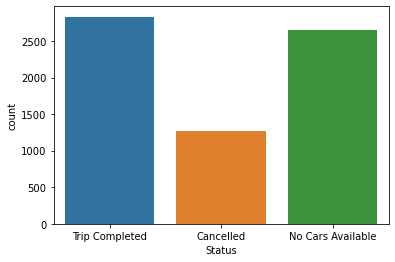

In [11]:
#check the frequency of different statuses
sns.countplot(x='Status', data=uber_df)

Clearly we can see that approximately 60% trips are either being *Cancelled* or *Cars are not available*, while out of the total *Not-Served* requests approx 30% are *Cancelled* while in 70% cases *Availability* was the issue.

Let's dig this down further and see the impact on `Pickup point`.

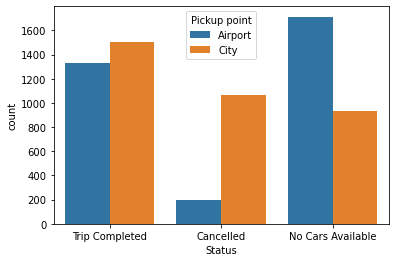

In [12]:
sns.countplot(x='Status', hue='Pickup point', data=uber_df)

So, it is quite visible that `Availability` is the most common issue at the `Airport`.

Next, let's see how the `Status` varies for different times of a day.

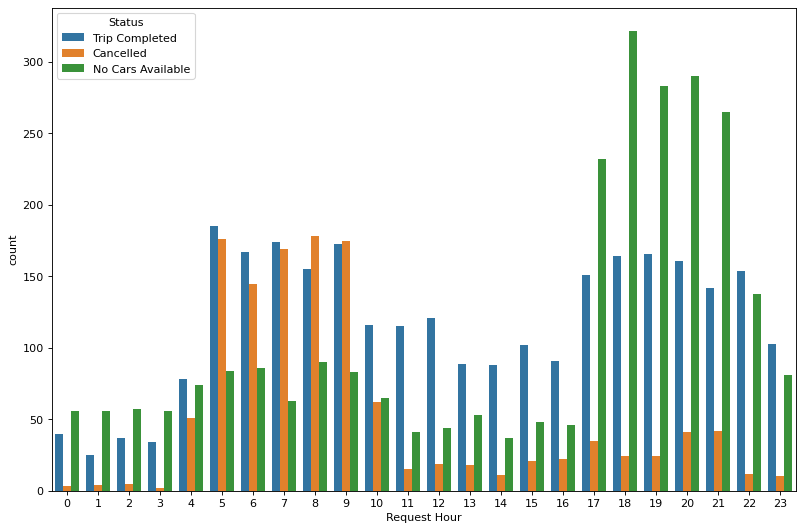

In [13]:
plt.figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')
sns.countplot(x='Request Hour', hue='Status', data=uber_df)

This is where we see the most affected time-slots in a day, while during *5-9 A.M.* `Cancellation` is the concern, on the other hand during *5-9 P.M.* `Availability` is extremely low.

Also, it's good to have a look at the `Unavailability` throughout the different `Days of Week`.

In [14]:
sns.countplot(x='Request Day', data=day_df[(uber_df.Status != 'Trip Completed')])

NameError: name 'day_df' is not defined

`Wednesday` seems to be the most affected day of a week here.

Let's see the `Unavailability` throughout the different `Hours of Day`

In [15]:
#group the data by the Request Hour for uncompleted requests
grouped_hour = uber_df[uber_df.Status != 'Trip Completed'].groupby('Request Hour')
#count the no of observations at each hour of a day
grouped_hour['Status'].count()

Request Hour
0      59
1      60
2      62
3      58
4     125
5     260
6     231
7     232
8     268
9     258
10    127
11     56
12     63
13     71
14     48
15     69
16     68
17    267
18    346
19    307
20    331
21    307
22    150
23     91
Name: Status, dtype: int64

Also, let's see the plot for the above data

In [16]:
#set the size for the plot
plt.figure(figsize=(8, 6))
#time series plot
sns.tsplot(grouped_hour['Status'].count())
plt.xlabel("Time of Day")
plt.ylabel("No. of gaps")
plt.show()

AttributeError: module 'seaborn' has no attribute 'tsplot'

<Figure size 576x432 with 0 Axes>

As the above graph clearly indicates, there are two slots in a day with the maximum number of gaps i.e. 4-10 early morning and 17-22 late evening.

Now when we have our target time-slots, it's better to filter them out in a seperate dataframe.

In [17]:
#create a dataframe from original Uber dataframe, with observations for the above identified time-slots & failed requests
uber_gap_df = uber_df[(((uber_df['Request Hour'] > 3) & (uber_df['Request Hour'] < 11)) | ((uber_df['Request Hour'] > 16) & (uber_df['Request Hour'] < 23))) & (uber_df['Status'] != 'Trip Completed')]

Next up is to see how the requests from City & Airport are affected during the identified slots.

Text(0, 0.5, 'No. of gaps')

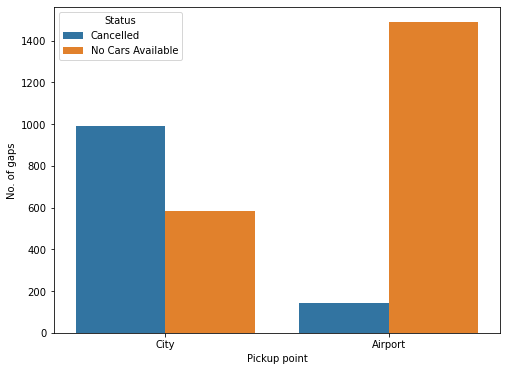

In [18]:
#plot the no of gaps per pickup point per Status
plt.figure(figsize=(8, 6))
sns.countplot(x='Pickup point', hue='Status', data=uber_gap_df)
plt.ylabel("No. of gaps")

In the gap dataframe, let's add a derived metric `slot` to do some interesting analysis.

In [19]:
#add new column 'slot' to the uber_gap_df
uber_gap_df['slot'] = ['Early Morning' if h<= 10 else 'Late Evening' for h in uber_gap_df['Request Hour']]

#group the uber_gap_df by 'pickup point', 'slot' and 'status'
grouped_gap = uber_gap_df.groupby(['Pickup point', 'slot', 'Status'])

<ipython-input-19-28f272542b9a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uber_gap_df['slot'] = ['Early Morning' if h<= 10 else 'Late Evening' for h in uber_gap_df['Request Hour']]


In [20]:
#create a temporary multi-indexed dataframe out of the grouped_gap object
slots_df = grouped_gap['Request Hour'].count()

print(slots_df)

Pickup point  slot           Status           
Airport       Early Morning  Cancelled              34
                             No Cars Available      68
              Late Evening   Cancelled             109
                             No Cars Available    1421
City          Early Morning  Cancelled             922
                             No Cars Available     477
              Late Evening   Cancelled              69
                             No Cars Available     109
Name: Request Hour, dtype: int64


Let's now derive plots from the dataframe `slots_df` to see the frequency of gaps during `Early morning` and `Late evening` for both, the requests from `City` and from `Airport`.

Text(0, 0.5, 'Total Gaps')

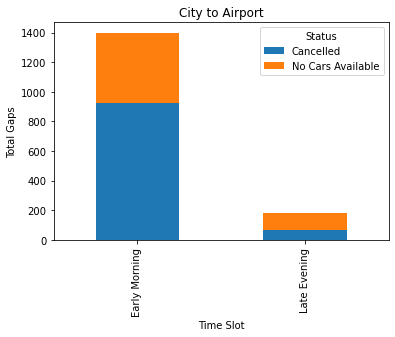

In [21]:
#plot the frequency distribution of gaps per slot for the requests for City to Airport trips.
slots_df['City'].unstack().plot(kind='bar', stacked=True)
plt.title("City to Airport")
plt.xlabel("Time Slot")
plt.ylabel("Total Gaps")

Text(0, 0.5, 'Total Gaps')

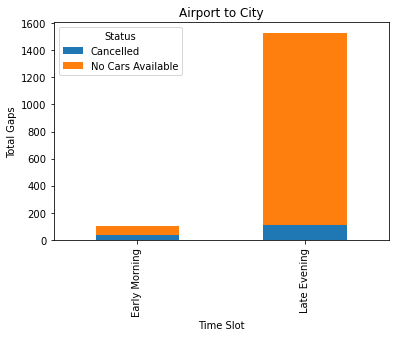

In [22]:
#plot the frequency distribution of gaps per slot for the requests for Airport to City trips.
slots_df['Airport'].unstack().plot(kind='bar', stacked=True)
plt.title("Airport to City")
plt.xlabel("Time Slot")
plt.ylabel("Total Gaps")

Looking at the above two distribution plots, it is very clear that there is an enormous gap `Tower` for the requests from City during the `Early morning` slot and from Airport during the `Late evening` slot.
Now checking the same plots closely, it is further quite visible that for the `Early morning Tower` from City over 70% cases are of `Cancellation` while for the `Late evening Tower` from Airport over 90% cases are of `Unavailability`